In [ ]:
#Import libraries
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt # plotting purposes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Define parameters

# dataset parameters
FNAME_PATTERN = 'drive/MyDrive/misa/IBSR_{}/IBSR_{}{}.nii.gz'
N_VOLUMES = 15
N_VOLUMES_TEST = 3
IMAGE_SIZE = (256,128,256)

# network parameters
N_CLASSES = 4
N_INPUT_CHANNELS = 1
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (32, 32)
array = ['01', '03', '04', '05', '06', '07', '08', '09', '16', '18', '11', '12', '13', '14', '17']
array_test = ['02', '10', '15']
# training, validation, test parameters
TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
VALIDATION_VOLUMES = [10, 11, 12, 13, 14]
TEST_VOLUMES = [0, 1, 2]

# data preparation parameters
CONTENT_THRESHOLD = 0.2

# training parameters
N_EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
LOSS = 'SparseCategoricalCrossentropy'

In [ ]:
#Mount drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define SegNet architecture
def get_unet(img_size=PATCH_SIZE, n_classes=N_CLASSES, n_input_channels=N_INPUT_CHANNELS, scale=1):
    inputs = keras.Input(shape=img_size + (n_input_channels, ))

    # Encoding path
    conv1 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    drop1 = layers.Dropout(rate=0.2)(conv1, training=True)
    max1 = layers.MaxPooling2D((2, 2))(drop1)

    conv2 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2 = layers.Dropout(rate=0.2)(conv2, training=True)
    max2 = layers.MaxPooling2D((2, 2))(drop2)

    conv3 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3 = layers.Dropout(rate=0.2)(conv3, training=True)
    max3 = layers.MaxPooling2D((2, 2))(drop3)

    lat = layers.Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4 = layers.Dropout(rate=0.2)(lat, training=True)

    # Decoding path
    up1 = layers.UpSampling2D((2, 2))(lat)
    concat1 = layers.concatenate([conv3, up1], axis=-1)
    conv4 = layers.Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop5 = layers.Dropout(rate=0.2)(conv4, training=True)
    
    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.concatenate([conv2, up2], axis=-1)
    conv5 = layers.Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop6 = layers.Dropout(rate=0.2)(conv5, training=True)


    up3 = layers.UpSampling2D((2, 2))(conv5)
    concat3 = layers.concatenate([conv1, up3], axis=-1)
    conv6 = layers.Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop7 = layers.Dropout(rate=0.2)(conv6, training=True)

    outputs = layers.Conv2D(n_classes, (1, 1), activation="softmax")(conv6)

    model = keras.Model(inputs, outputs)

    return model

In [ ]:
# Load data
def load_data(n_volumes=N_VOLUMES, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    labels = np.zeros((n_volumes, *image_size, 1))
    for i in range(len(array)) :
        img_data = nib.load(fname_pattern.format(array[i], array[i], ''))
        T1_volumes[i] = img_data.get_fdata()
        seg_data = nib.load(fname_pattern.format(array[i], array[i], '_seg'))
        labels[i] = seg_data.get_fdata()
    return (T1_volumes, labels)

In [ ]:
(T1_volumes,labels) = load_data()

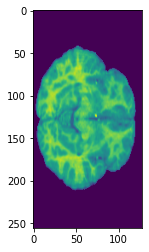

In [ ]:
plt.imshow(T1_volumes[14, :, :, 120, 0])

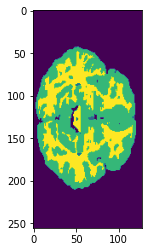

In [ ]:
plt.imshow(labels[14, :, :, 120, 0])

In [ ]:
# Split into training, validation and testing
training_volumes_T1 = T1_volumes[TRAINING_VOLUMES]
training_labels = labels[TRAINING_VOLUMES]

validation_volumes_T1 = T1_volumes[VALIDATION_VOLUMES]
validation_labels = labels[VALIDATION_VOLUMES]

#testing_volumes_T1 = T1_volumes[TEST_VOLUMES]
#testing_labels = labels[TEST_VOLUMES]

In [ ]:
#plt.imshow(testing_volumes_T1[0, :, :, 120, 0])
#plt.imshow(training_labels[0, :, :, 120, 0])

In [ ]:
# Pre-process data
def z_score_standardisation(x, avg, std):
    return (x-avg)/std

ref_avg = training_volumes_T1[training_labels!=0].mean()
ref_std = training_volumes_T1[training_labels!=0].std()

training_volumes_T1 = z_score_standardisation(training_volumes_T1, ref_avg, ref_std)
validation_volumes_T1 = z_score_standardisation(validation_volumes_T1, ref_avg, ref_std)

In [ ]:
# Extract useful patches
def extract_patches(x, patch_size, patch_stride) :
    return tf.image.extract_patches(
    x,
    sizes=[1, *patch_size, 1],
    strides=[1, *patch_stride, 1],
    rates=[1, 1, 1, 1],
    padding='SAME', name=None)

In [ ]:
def extract_useful_patches(
    volumes, labels,
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    threshold=CONTENT_THRESHOLD,
    num_classes=N_CLASSES) :
    volumes = volumes.reshape([-1, image_size[1], image_size[2], 1])
    labels = labels.reshape([-1, image_size[1], image_size[2], 1])

    vol_patches = extract_patches(volumes, patch_size, stride).numpy()
    seg_patches = extract_patches(labels, patch_size, stride).numpy()

    vol_patches = vol_patches.reshape([-1, *patch_size, 1])
    seg_patches = seg_patches.reshape([-1, *patch_size, ])

    foreground_mask = seg_patches != 0

    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * np.prod(patch_size)

    vol_patches = vol_patches[useful_patches]
    seg_patches = seg_patches[useful_patches]

  
    return (vol_patches, seg_patches)

In [ ]:
# extract patches from training set
(training_patches_T1, training_patches_seg) = extract_useful_patches(training_volumes_T1, training_labels)

# extract patches from validation set
(validation_patches_T1, validation_patches_seg) = extract_useful_patches(validation_volumes_T1, validation_labels)

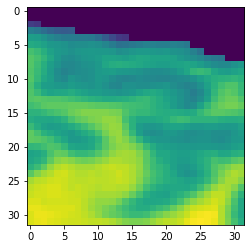

In [ ]:
plt.imshow(training_patches_T1[12746, :, :, 0])

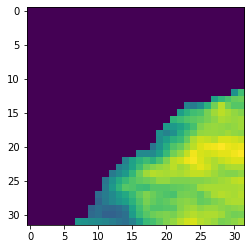

In [ ]:
plt.imshow(validation_patches_T1[6647, :, :, 0])

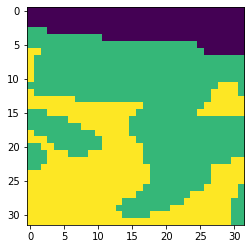

In [ ]:
plt.imshow(training_patches_seg[12746, :,  :])

In [ ]:
# Train network
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True)
]

segnet = get_unet()
segnet.compile(optimizer=OPTIMISER, loss=LOSS, metrics=['accuracy'])
history = segnet.fit(
    x=training_patches_T1, 
    y=training_patches_seg,
    validation_data=(validation_patches_T1, validation_patches_seg),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/100
453/453 [==============================] - 15s 31ms/step - loss: 0.3412 - accuracy: 0.8607 - val_loss: 1.5558 - val_accuracy: 0.8461
Epoch 2/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1977 - accuracy: 0.9202 - val_loss: 0.9807 - val_accuracy: 0.8952
Epoch 3/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1611 - accuracy: 0.9340 - val_loss: 1.5937 - val_accuracy: 0.8830
Epoch 4/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1434 - accuracy: 0.9407 - val_loss: 2.2988 - val_accuracy: 0.8755
Epoch 5/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1276 - accuracy: 0.9471 - val_loss: 2.4059 - val_accuracy: 0.8738
Epoch 6/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1178 - accuracy: 0.9510 - val_loss: 2.5275 - val_accuracy: 0.8685
Epoch 7/100
453/453 [==============================] - 13s 29ms/step - loss: 0.1099 - accuracy: 0.9541 - val_loss: 2.3252 - val_ac

In [ ]:
# Load best model
segnet = get_unet(
    img_size=(IMAGE_SIZE[1], IMAGE_SIZE[2]),
    n_classes=N_CLASSES,
    n_input_channels=N_INPUT_CHANNELS)
segnet.compile(optimizer=OPTIMISER, loss=LOSS, metrics=['accuracy'])
segnet.load_weights('model.h5')

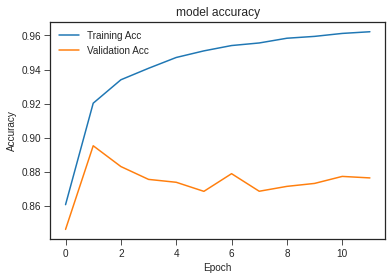

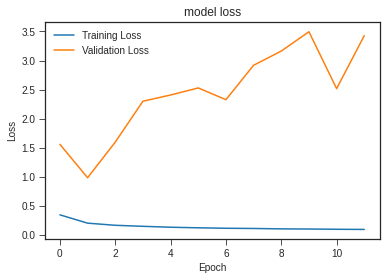

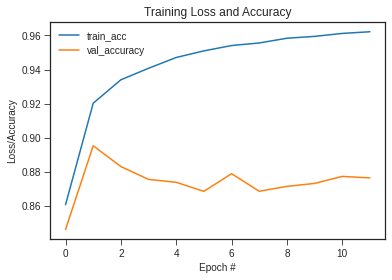

In [ ]:
import matplotlib
plt.style.use("seaborn-ticks")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Validation Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

plt.figure()
N = 12

plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")


In [ ]:
def load_data(n_volumes=N_VOLUMES_TEST, image_size=IMAGE_SIZE, fname_pattern=FNAME_PATTERN) :
    T1_volumes = np.zeros((n_volumes, *image_size, 1))
    #labels = np.zeros((n_volumes, *image_size, 1))
    for i in range(len(array_test)) :
        img_data = nib.load(fname_pattern.format(array_test[i], array_test[i], ''))
        T1_volumes[i] = img_data.get_fdata()
        #seg_data = nib.load(fname_pattern.format(array[i], array[i], '_seg'))
        #labels[i] = seg_data.get_fdata()
    return (T1_volumes)

In [ ]:
(T1_volumes_test) = load_data()

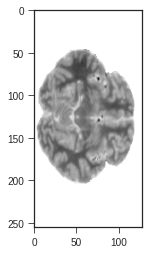

In [ ]:
testing_volumes_T1 = T1_volumes_test[TEST_VOLUMES]
plt.imshow(T1_volumes_test[2, :, :, 120, 0])

In [ ]:
# Prepare test data
testing_volumes_T1 = z_score_standardisation(testing_volumes_T1, ref_avg, ref_std)

In [ ]:
testing_volumes_T1_processed1 = testing_volumes_T1[0].reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_volumes_T1_processed2 = testing_volumes_T1[1].reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
testing_volumes_T1_processed3 = testing_volumes_T1[2].reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
#testing_labels_processed = testing_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])


In [ ]:
# Predict labels for test data
prediction1 = segnet.predict(x=testing_volumes_T1_processed1)
prediction2 = segnet.predict(x=testing_volumes_T1_processed2)
prediction3 = segnet.predict(x=testing_volumes_T1_processed3)
prediction1 = np.argmax(prediction1, axis=3)
prediction2 = np.argmax(prediction2, axis=3)
prediction3 = np.argmax(prediction3, axis=3)


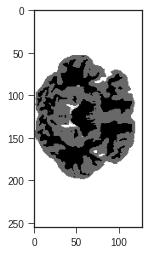

In [ ]:
plt.imshow(prediction1[:, :, 120])

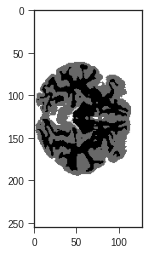

In [ ]:
plt.imshow(prediction2[:, :, 120])

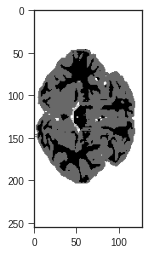

In [ ]:
plt.imshow(prediction3[:, :, 120])

In [ ]:
array_test = ['02', '10', '15']

image1 = nib.load('drive/MyDrive/misa/IBSR_02/IBSR_02.nii.gz')
image2 = nib.load('drive/MyDrive/misa/IBSR_10/IBSR_10.nii.gz')
image3 = nib.load('drive/MyDrive/misa/IBSR_15/IBSR_15.nii.gz')
header_info1 = image1.header
header_info2 = image2.header
header_info3 = image3.header

#c = np.array(image.get_fdata())
ni_img1 = nib.Nifti1Image(prediction1, image1.affine, header_info1)
ni_img2 = nib.Nifti1Image(prediction2, image2.affine, header_info2)
ni_img3 = nib.Nifti1Image(prediction3, image3.affine, header_info3)

nib.save(ni_img1, 'drive/MyDrive/misa/IBSR_02_segmented.nii.gz')
nib.save(ni_img2, 'drive/MyDrive/misa/IBSR_10_segmented.nii.gz')
nib.save(ni_img3, 'drive/MyDrive/misa/IBSR_15_segmented.nii.gz')